# 回归和分类

In [1]:
import math
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import graphviz

# 用于创建一个具有默认值的字典
from collections import defaultdict
# 方便地在Jupyter Notebook或IPython环境中呈现和交互式操作SVG图像
from IPython.display import SVG

from sklearn import tree
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor,export_graphviz
from sklearn.ensemble import AdaBoostClassifier,AdaBoostRegressor,RandomForestClassifier,RandomForestRegressor,BaggingClassifier,BaggingRegressor
from sklearn.svm import SVC,SVR
from sklearn.preprocessing import StandardScaler

import statsmodels as tsm
import matplotlib as tplt
import sklearn as tsk

### 一些自编函数

In [2]:
#单独模型分类交叉验证
def Fold(u,Z=5,seed=1010):
    u = np.array(u).reshape(-1)
    id = np.arange(len(u))
    zid = []
    ID = []
    np.random.seed(seed)
    for i in np.unique(u):
        n = sum(u == i)
        ID.extend(id[u==i])
        k = (list(range(Z))*int(n/Z+1))[:n]
        np.random.shuffle(k)
        zid.extend(k)
    zid = np.array(zid)
    ID = np.array(ID)
    zid = zid[np.argsort(ID)]
    return zid

In [4]:
def BarPlot(A,xlab='',ylab='',title='',size=[20,20,30,20,15]):
    plt.figure(figsize=(20,7))
    plt.barh(range(len(A)),A.values(),color='navy',height=0.6)
    plt.xlabel(xlab,size=size[0])
    plt.ylabel(ylab,size=size[1])
    plt.title(title,size=size[2])
    plt.yticks(np.arange(len(A)),A.keys(),size=size[3])
    for v,u in enumerate(A.values()):
        plt.text(u,v,str(round(u,4)),va='center',color='navy',size=size[4])
    plt.show()


前面内容中涉及到的大多都是单个变量，很少涉及到多个变量之间的影响。但是，世界上任何事物都是相互联系的，绝大多数真实的数据都包含着多个变量的观测值，数据科学绝大多数应用都涉及多个变量之间的关系。**发现多个变量之间的规律，并且用总结出来的模型去帮助人们进行预测或决策，才是数据科学的最终目的。**

# 数据科学核心是有监督学习的预测

一般来说，统计可以根据目前所拥有的信息(数据)来建立人们所关心的变量和其他有关变量的关系，这种关系一般称为模型。假设我们用**Y**表示感兴趣的变量，用**X**表示其他可能与**Y**有关的变量(**X**也可能是由若干变量组成的向量)，所需要的建立一个函数关系**Y=f(X)**。这里**Y**称为因变量和响应变量，而**X**称为自变量，也称为解释变量或协变量。建立这种关系的过程叫做**回归**或者**分类**。

回归和分类在数据科学中统称为有监督的学习或者有指导的学习，即有**目标变量或者因变量的建模**。回归和分类的性质在于因变量的性质，当因变量为**数量变量**时，叫做回归。当因变量为**分类变量**时，叫做分类。任何可预测的模型都是“学习”出来的，也就是说，无论是以数学公式或代码描述的模型，必须按照某种标准通过**真实数据**来获得这些模型中**参数**或者**选项的取值**，这就是学习的过程。而标准则是以对目标变量预测精度为标准，预测精度可以通过交叉验证来获得，也就是用一部分未参与建模的数据来测试模型的预测精度。(训练集与测试集划分思想)

数据科学模型应该满足的三个原则：可预测性、可计算性、稳定性。预测是目标，可计算性及稳定性是有效预测的保证，预测精度是衡量模型的优劣标准。

## 通过案例数据理解有监督的学习：分类问题

In [29]:
w = pd.read_csv("../data/Bidding.csv").iloc[:, 3:]
w

,Bidder_Tendency,Bidding_Ratio,Successive_Outbidding,Last_Bidding,Auction_Bids,Starting_Price_Average,Early_Bidding,Winning_Ratio,Auction_Duration,Class
0,0.200000,0.400000,0.0,0.000028,0.000000,0.993593,0.000028,0.666667,5,0
1,0.024390,0.200000,0.0,0.013123,0.000000,0.993593,0.013123,0.944444,5,0
2,0.142857,0.200000,0.0,0.003042,0.000000,0.993593,0.003042,1.000000,5,0
3,0.100000,0.200000,0.0,0.097477,0.000000,0.993593,0.097477,1.000000,5,0
4,0.051282,0.222222,0.0,0.001318,0.000000,0.000000,0.001242,0.500000,7,0
...,...,...,...,...,...,...,...,...,...,...
6316,0.333333,0.160000,1.0,0.738557,0.280000,0.993593,0.686358,0.888889,3,1
6317,0.030612,0.130435,0.0,0.005754,0.217391,0.993593,0.000010,0.878788,7,0
6318,0.055556,0.043478,0.0,0.015663,0.217391,0.993593,0.015663,0.000000,7,0
6319,0.076923,0.086957,0.0,0.068694,0.217391,0.993593,0.000415,0.000000,7,0


<function matplotlib.pyplot.show(close=None, block=None)>

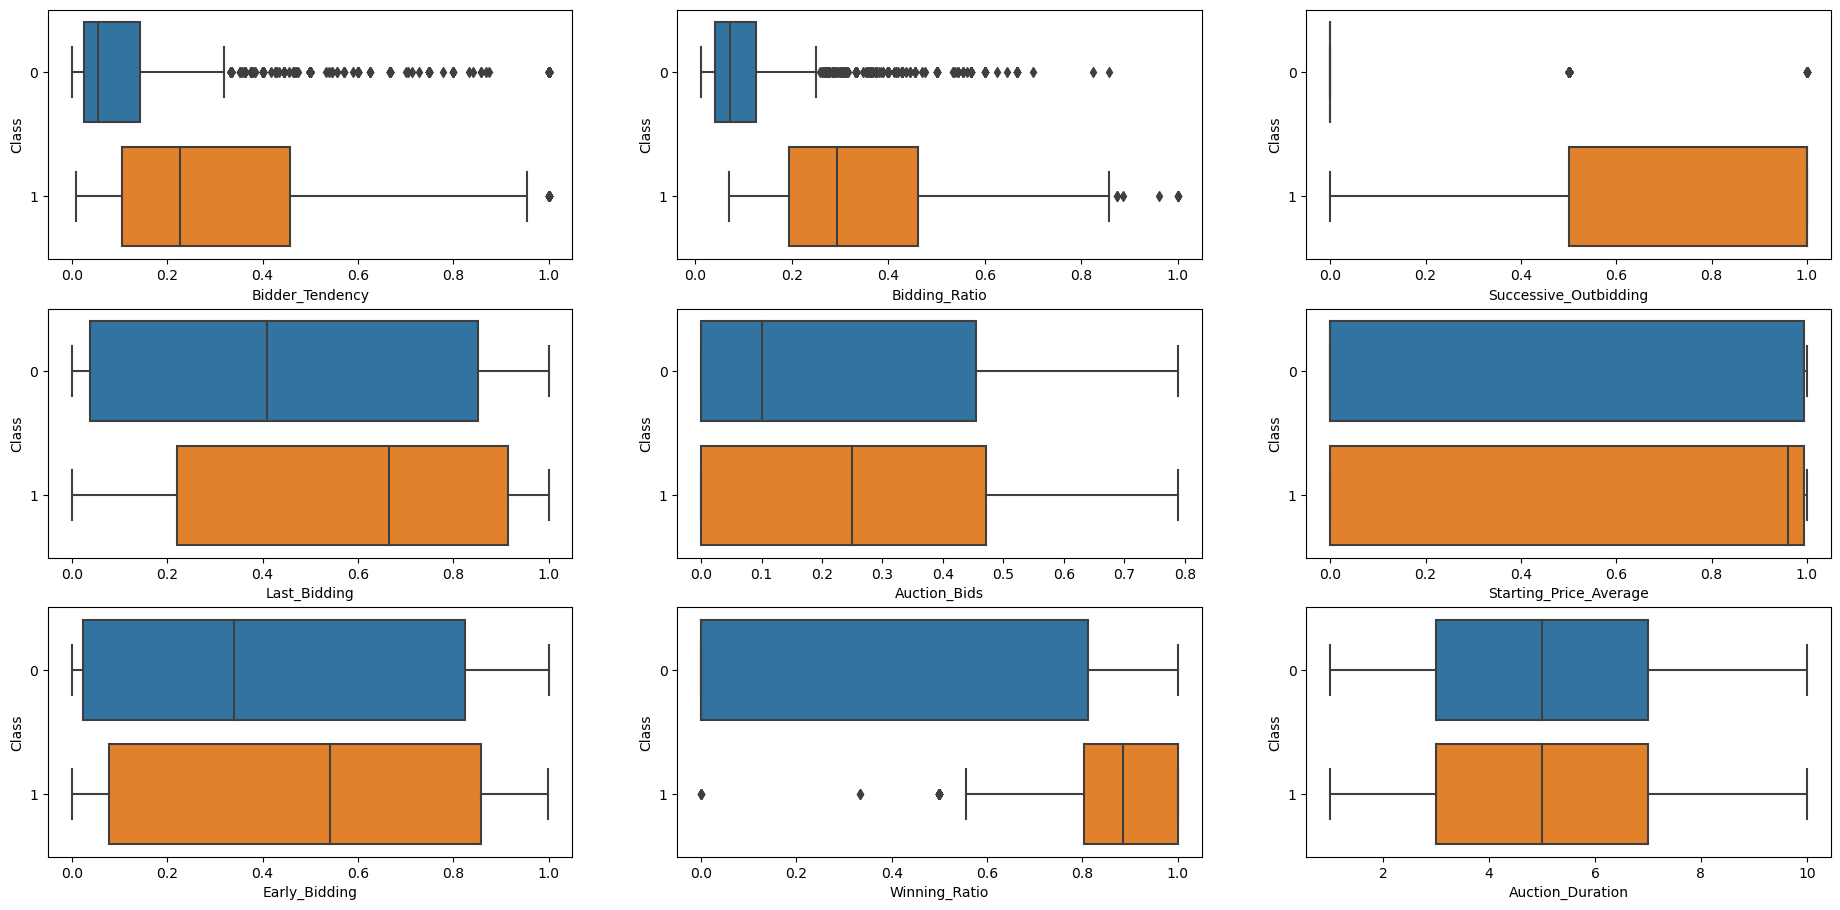

In [6]:
w = pd.read_csv("../data/Bidding.csv").iloc[:,3:]
# 设置字体为宋体
#plt.rcParams['font.sans-serif'] = 'SimSun'
plt.figure(figsize=(23,11))
for i,j in enumerate(w.columns[:-1]):
    plt.subplot(3,3,i+1)
    sns.boxplot(y="Class",x=j,data=w,dodge=True,orient='h')
plt.show

每个自变量与因变量之间的关系盒装图，从图中可以看出每个数量变量对目标变量的影响。Successive_Outbidding、Winning_Ratio、Bidding_Ratio造成了Class的巨大差距。Auction_Bids几乎与Class无影响。

**但是必须注意的是，这些自变量不是互相独立的，有些变量单独似乎对因变量影响不大，但在某种组合后可能就会有不可忽视的影响**

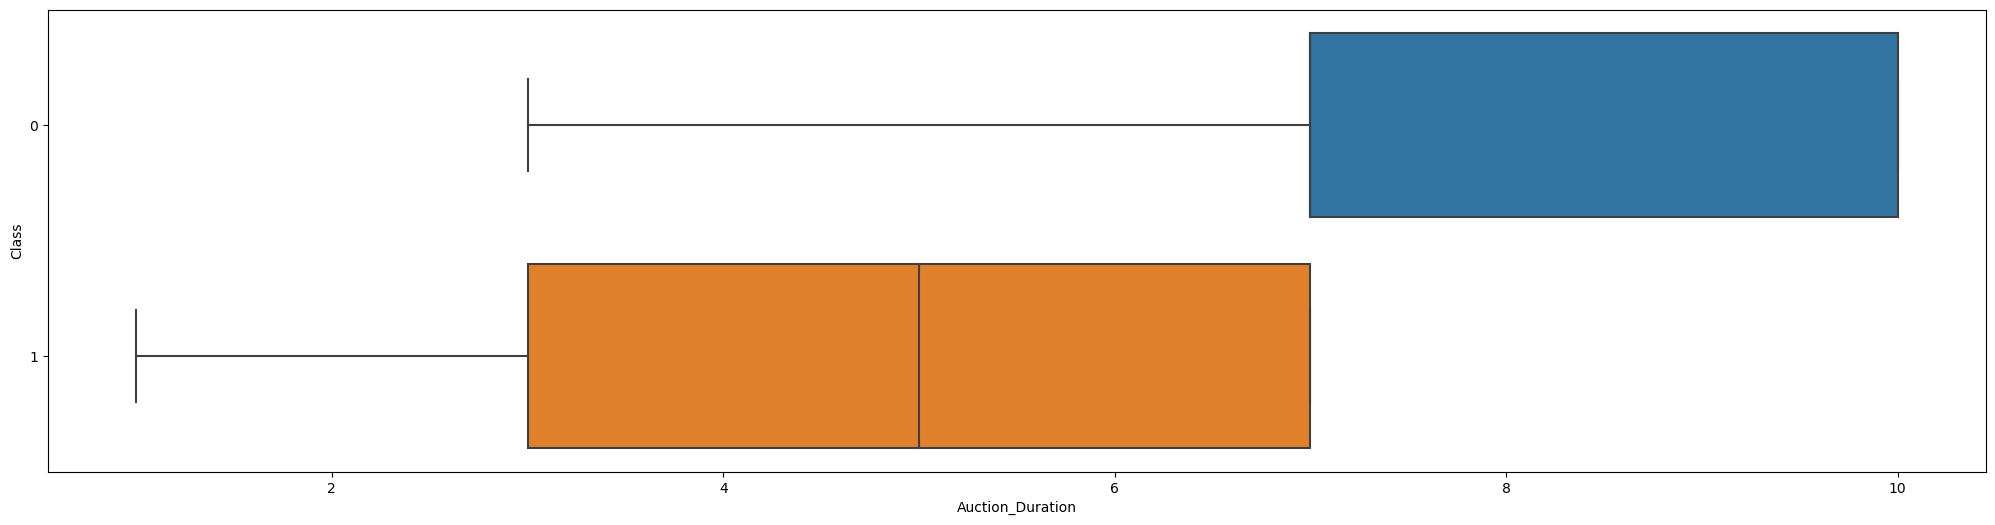

In [7]:
plt.figure(figsize=(25,6))
w1 = w[w['Successive_Outbidding']>0.75]
sns.boxplot(y="Class",x=j,data=w1,dodge=True,orient='h')
plt.show()

在任何数据分析中，简单的诸如散点图、或者其他形式的(多重盒装图)描述两个变量之间的图形无法描述更深层次的关系，往往具有误导作用。不幸的是，人类的感官及手段具有局限性，无法实现交高层次的可视化，因此，多数情况下必须使用其他方式来探索数据之间的关系。在多数情况系，自变量总体对于因变量预测的精确度是一个最重要的度量。

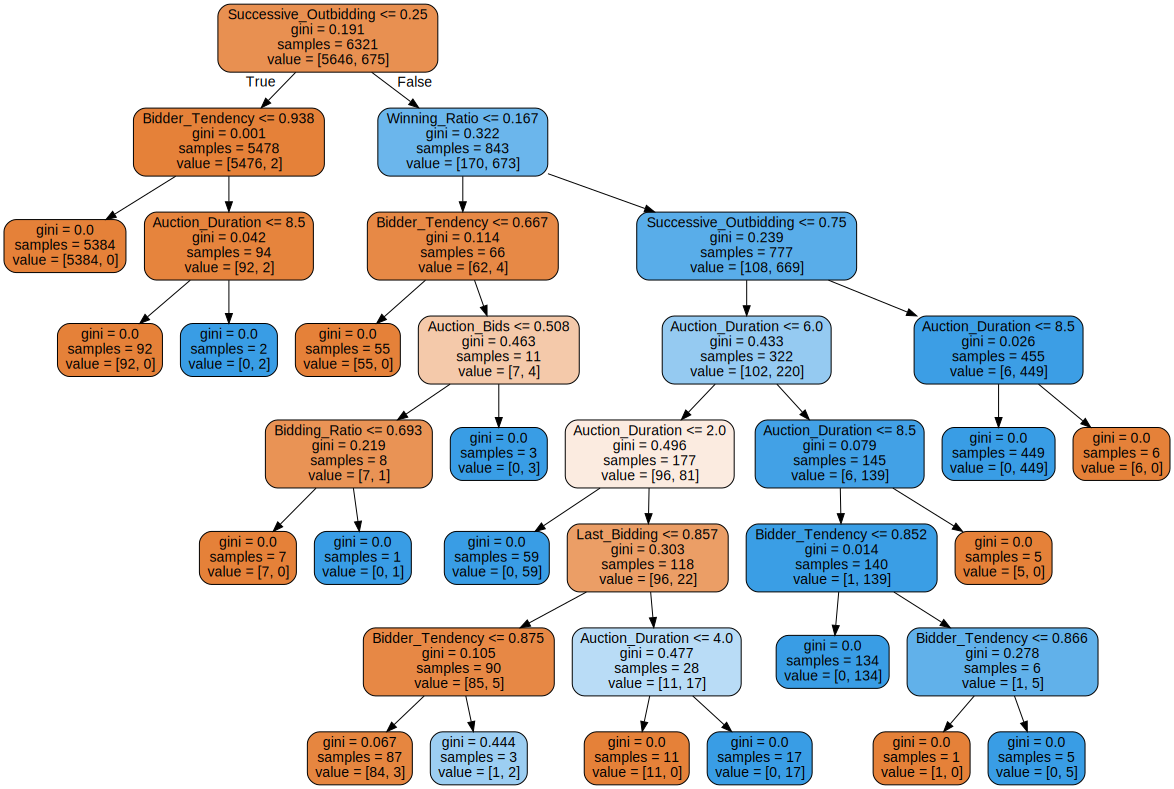

In [8]:
x = w.iloc[:,: -1]
y = w.iloc[:,-1].astype('category')
clf = DecisionTreeClassifier(max_depth=7)
clf = clf.fit(x,y)

dot_data = tree.export_graphviz(clf,out_file=None,feature_names=x.columns,rounded=True,filled=True)
graph = graphviz.Source(dot_data)
graph


In [9]:
def SCCV(X,y,clf,Z=10,seed=1010):
    n = len(y)
    Zid = Fold(y,Z,seed=1010)
    Y_pred=np.zeros(n)
    for j in range(Z):
        clf.fit(X[Zid!=j],y[Zid!=j])
        Y_pred[Zid == j]=clf.predict(X[Zid==j])
    cfm = confusion_matrix(y,Y_pred)
    error = np.mean(y!=Y_pred)
    return Y_pred,cfm,error


In [10]:
clf = DecisionTreeClassifier(max_depth=7)
pred,cfm,error = SCCV(x,y,clf,Z=10,seed=1010)
print("confusion_matrix\n",cfm,"\nerror=",error)

confusion_matrix
 [[5642    4]
 [   9  666]] 
error= 0.0020566366081316246


In [47]:
names = ["Bagging","Random Forest","AdaBoost","Logit"]
classifiers = [
    BaggingClassifier(n_estimators=100,random_state=1010),
    RandomForestClassifier(n_estimators=500, random_state=0),
    AdaBoostClassifier(n_estimators=100, random_state=0),
    LogisticRegression(solver="liblinear")]
CLS = dict(zip(names,classifiers))
# 假设你有训练集X_train和目标变量y_train

for name, clf in CLS.items():
    scores = cross_val_score(clf, x, y, cv=5, scoring='accuracy')
    print(f"{name}: {scores.mean()}")



Bagging: 0.9977853104517937
Random Forest: 0.993988092259969
AdaBoost: 0.9941469455145844
Logit: 0.9753193325661679


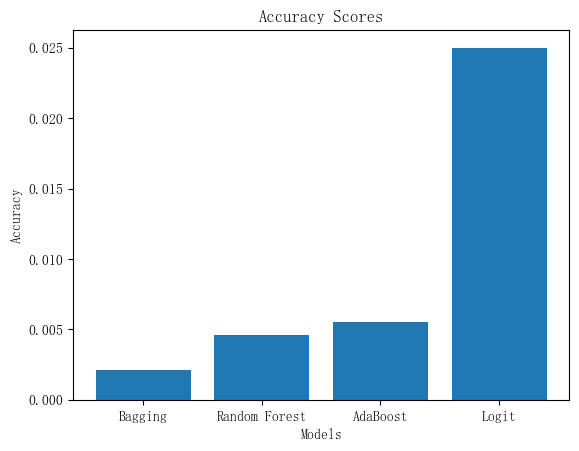

In [46]:
dic = {"Bagging": 0.0021,
       "Random Forest": 0.0046,
       "AdaBoost": 0.0055,
       "Logit": 0.025}
# 提取字典中的键和值
labels = dic.keys()
values = dic.values()
# 绘制直方图
plt.bar(labels, values)
# 添加标题和标签
plt.title("Accuracy Scores")
plt.xlabel("Models")
plt.ylabel("Accuracy")

# 显示图形
plt.show()


In [12]:
u = pd.read_csv("../data/Concrete.csv")


,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77


<Figure size 2500x800 with 0 Axes>

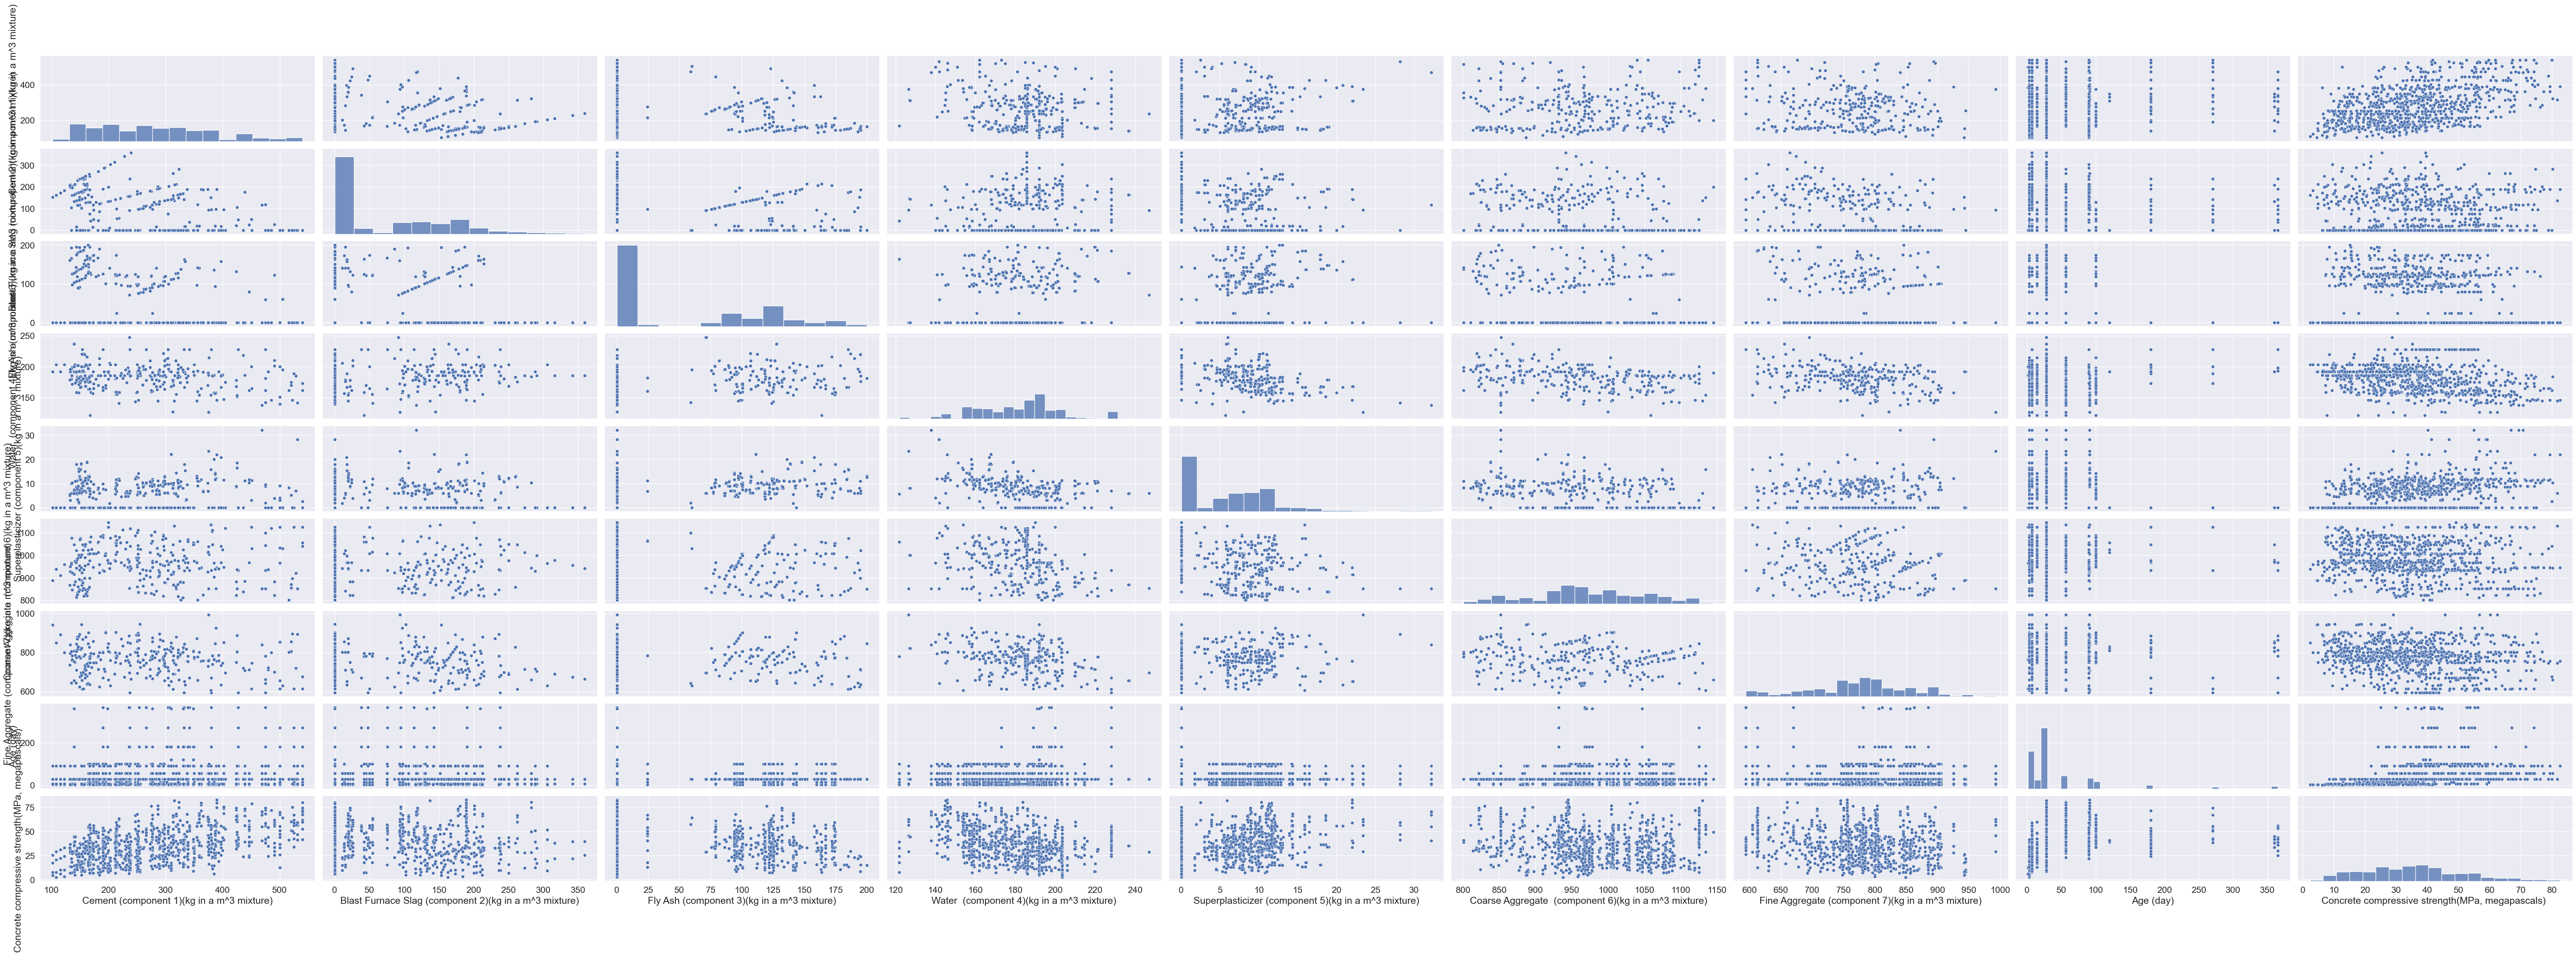

In [15]:
plt.figure(figsize=(25,8))
sns.set(font_scale=1.5)
sns.pairplot(u,aspect=3)
plt.show()

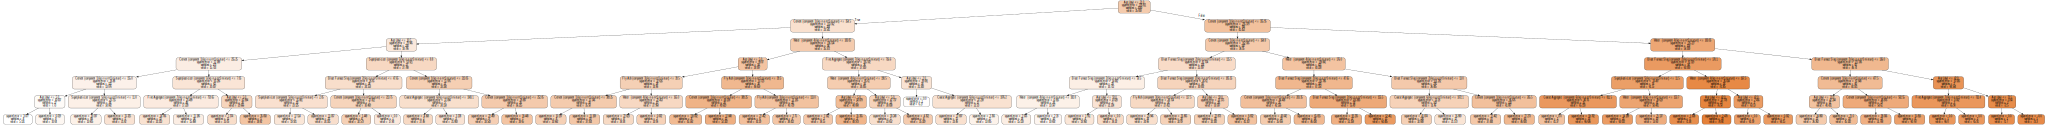

In [16]:
x = u.iloc[:,:-1] #选取除了后一列的所有列
y = u.iloc[:,-1] #选取最后一列
reg = DecisionTreeRegressor(max_depth=6)
reg.fit(x,y)
dot_data = tree.export_graphviz(reg,out_file=None,feature_names=x.columns,rounded=True,filled=True)
graph = graphviz.Source(dot_data)
graph


## 交叉验证
交叉验证（Cross-validation）是一种统计学中常用的模型评估方法，用于评估机器学习模型性能和泛化能力。它通过将数据集划分为训练集和验证集，并多次重复进行模型练和评估，从得到更可靠的模型性指标。

在交叉验证中，首先将原始数据集划分**K个大小相等**的集，通常称为**折（fold）**。然后选择其中一个折作为验证，剩下的K-1个折作为训练集。接下，使用训练集对模型进行训练，并使用验证集评估模型的性能。这个过程会重复K次，每次选择不的验证集，最终到K个模型性能指标的平均值作为模型的性能评估结果。

交验证的主要优点可以充分利用有的数据集，减少因数据划分不合理引入的偏差。它还可以供对模型性的稳定估计，帮助选择合适的模型参数或比较不同模型之间的性能差。常见的交叉验证方法包括k折交叉验证、留一交叉验证（Leave-One-Out Cross-Validation，LOOCV）等。

总之，交叉验证是一种常用的模型评估方法，可以帮助评估机器学模型的性能和泛化能力，并在模选择和参数调优中起重要作用。


准确率（Accuracy）是指分类器正确预测的样本数占总样本数的比例。它衡了模型整体预测的准确程度。

精确率（Precision）是指在所有被分类为例的样本中真正例的比例。它衡量了模型在预测为正例的样本中的准确程。

召回率（Recall）指在所有实际为正例的样本中，正确预测为正例的比。它衡量了模型对于正例样本的查全率。

F1 分数是综合考虑确率和召回率指标，它是确率和召回率的调和均值。F1 分数越高，表示模型在同时考虑准率和召回率时表现越好。